# Expected Epidemic Size of Mask Model


## 1. Condition on num of neighbors from lower level
$P(A_{L, 0}) = f_0(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(A_{L, 1}) = f_1(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(\text{wear a mask}) = m$

$A_{L, 0}$ := Node v becomes **active** at level L given he **wear** a mask

$A_{L, 1}$ := Node v becomes **active** at level L given he **doesn't wears** a mask




$B_k$ := Node v has $k - 1$ lower level neighbors

$P(A_{L, i}) = \sum_{k = 1}^{\infty}{P(A_{L, i} | B_k) * P(B_k)}$

where

$i = 0,1$

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$




## 2. Condition on num of neighbors wearing a mask

$N$ := Num of neighbors wearing masks 
 
$N \sim \operatorname{Binomial}\left(k - 1, m\right)$


$ P(A_{L, i} | B_k) = \sum_{n = 0}^{k - 1} P(A_{L, i} | B_k, N = n) * \left(\begin{array}{c}
k - 1 \\
n
\end{array}\right) * m^{n} * (1 - m)^{k - 1 - n} $

## 3. Condition on num of active lower level neighbors

$I_0$ := $I_0$ of $k-1$ lower level neighbors active and wear masks

$I_1$ := $I_1$ of $k-1$ lower level neighbors active and don't wear masks

$I_0 \sim \operatorname{Binomial}\left(n, A_{L-1,0}\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, A_{L-1,1}\right)$


$P(A_{L, i} | B_k, N = n) = \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k-1-n}P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right) \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * A_{L-1, 0}^{k_0} * (1 - A_{L-1,0})^{n - k_0} * A_{L-1, 1}^{k_1} * (1 - A_{L-1, 1})^{k - 1 - n - k_1}$

where

$i = 0,1$

## 4. $P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1)$

$R$ := $B_k, N = n, I_0 = k_0, I_1 = k_1$

### 4.1 $P(A_{L,0} | R)$

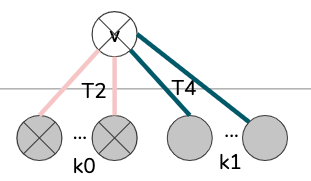

$P(A_{L,0} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v wears a mask} | R)$

$ = 1 - T_2^{k_0} * T_4^{k_1}$

### 4.1 $P(A_{L,1} | R)$

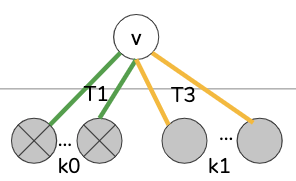

$P(A_{L,1} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v doesn't a mask} | R)$

$ = 1 - T_1^{k_0} * T_3^{k_1}$

## 3.b $P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1)$

$R$ := $B_k, I_0 = k_0, I_1 = k_1$

$P(A_{L, i} | R)$ = $(1 - (1 - Q_1)^{k_0} * (1 - Q_2)^{k_1}) * m^{(1 - i)} * (1 - m)^i$

In the experiement code, we can still shuffle. But we don't use the strain we get by this shuffling. 

The transmissibility is decided by the edge types in advance. => no relationship with who gives us the infection or what strain we have.

(Paper code, the transmissibility is decided on the previous transmission steps)

## 3.a Condition on the num of infected lower level neighbors *


$X$ := Num of infection received from active lower level neighbors **wearing** masks 

$Y$ := Num of infection received from active lower level neighbors **not wearing** masks 


$Q_1 = T_1 * (1 - m) + T_2 * m$ => Lower level neighbors' avg transmissibility if wear masks

$Q_2 = T_3 * (1 - m) + T_4 * m$ => Lower level neighbors' avg transmissibility if don't wear masks


$X \sim \operatorname{Binomial}\left(k_0, Q_1\right)$

$Y \sim \operatorname{Binomial}\left(k_1, Q_2\right)$


$P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1)=$

$\sum_{x = 0}^{k_0}\sum_{y = 0}^{k_1}\left(\begin{array}{c}
k_0 \\
x
\end{array}\right)  \left(\begin{array}{c}
k_1 \\
y
\end{array}\right) * Q_1^{x} * Q_2^{y} * (1 - Q_1)^{(k_0 -x)} * (1 - Q_2)^{(k_1 - y)} * P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1, X = x, Y = y)$

where

$i = 0,1$



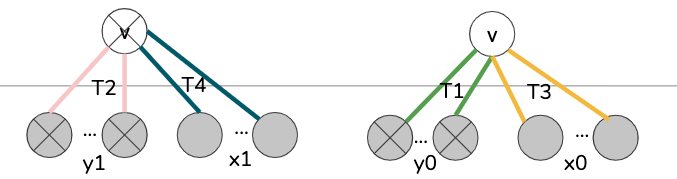

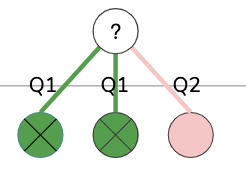


## 4.a $P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1, X = x, Y = y)$ *

Let 
$R := B_k, I_0 = k_0, I_1 = k_1, X = x, Y = y$

### Goal: $P(A_{L, i} | R)$

Recall: $A_{L, 0}$ := Node v becomes **active** at level L and he **doesn't wear** a mask



$M$ := Node v wears a mask

$C$ := Node v becomes active

$A_{L, 1} | R = (C M) | R$

$A_{L, 0} | R = (C\overline M) | R$


(R gives information about the estimated percentage of people who wear masks)

$P((C M) | R) = P(C | RM) * P(M)$

$P((C\overline M) | R ) = P(C | R \overline M) * P(\overline M)$

##### p.s. Notation from Slides Page 85

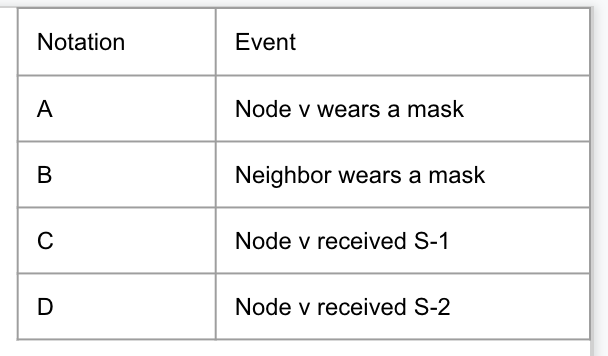 


# Question
1. Prob of emergence
Prob of emergence = 1 - Prob of extinction.

Prob of ext: q = f(q)

====> try solve(), ====> start from 1, 

2. Epidemic Size
$ q_{L + 1} = f(q_L), L \rightarrow \infty$

3. $q_0$ should be started from 0?
====> start from 1, 
4. Where is the threshold to determine the epidemic in the derivation?
====> 5\%
5. Where is the threshold to determine the emergence in the derivation?

====> 200,000 nodes, plot more details around threshold

## This time:

1. Does Mask Model need shuffle?

Mask model doesn't need shuffle becuase it doesn't need to decide which strain to get so no need to have the randomness about which strain to have. 

For Mask strain, just do all the ber trials one by one, as long as one guy give me infection I get it.

2. The fsolve only has non-zero roots when the Q1 Q2 are large enough

| RV/Event | Mask | Mutation  | From which model |
|----------|------|-----------|------|
| $A_{L,0}$ | Node v becomes active \& wears a mask  | $AC$ + $AD$  | Mask model  |   
| $A_{L,1}$ | Node v becomes active \& not wearing a mask  | $\overline AC$ + $\overline AD$  |  Mask model |  
| $R$  | Condition on active neighbors  | An RV to check the only one neigbor's mask (we assume he is active): $B$ | Mask model  |  
| $A_{L,0} | R$  | Node v get infected by anyone \& wears a mask, given active neighbors | $(AC + AD)|B$ | Mask model  | 
| $\mu11$  |   | $P(A | C)$  | Mutation model  |
| $\mu12$  |   | $P(\overline A | C)$  | Mutation model  |  
| $\mu21$  |   | $P(A | D)$  | Mutation model  |
| $\mu22$  |   | $P(\overline A | D)$  | Mutation model  |  
| $A | X = x, Y = y$  |   | $x Cs, y Ds  |  k_0 Bs, k_1 \overline B$  | Mutation model  | 


In [68]:
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson
from scipy import optimize 

In [4]:
def nCk(n,k): 
    return int(round(reduce(mul, (float(n-i)/(i+1) for i in range(k)), 1)))

In [19]:
def P_A_given_R(i, Q1, Q2, k0, k1, m):
    res = (1 - ((1 - Q1) ** k0) * ((1 - Q2) ** k1)) * (m ** (1 - i)) * ((1 - m) ** i)
    assert res >= 0, "P_A_given_R should be greater than 0"
    assert res <= 1, "P_A_given_R should be less than 1"
    return res

In [52]:
def P_A_given_B(i, k, A_0, A_1, Q1, Q2, m):
    one_minus_A01 = 1 - A_0 - A_1
    p_ab = 0
    for k0 in range(k):
        for k1 in range(k - k0):
            p_a_given_r = P_A_given_R(i, Q1, Q2, k0, k1, m)
            p_ab += p_a_given_r * \
                    nCk(k - 1, k0) * \
                    nCk(k - 1 - k0, k1) * \
                    (A_0 ** k0) * (A_1 ** k1) * \
                    (one_minus_A01 ** (k - 1 - k0 - k1))


#     assert p_ab >= 0, "P_AB should be greater than 0"
#     assert p_ab <= 1, "P_AB should be less than 1"
    return p_ab

In [110]:
def P_A(i, mean_degree, nodeN, Q1, Q2, m, A_0, A_1):
    P_k_dict, k_max = generate_degree_list(mean_degree, nodeN)
#     print(k_max)
    pa_L = 0
    for k in range(1, k_max):
        if k not in P_k_dict.keys():
            p_k = 0
        else:
            p_k = P_k_dict[k]
        p_b = k * p_k / mean_degree
        p_ab = P_A_given_B(i, k, A_0, A_1, Q1, Q2, m)
        pa_L += p_ab * p_b
        
#         assert pa_L >= 0, "P_A should be greater than 0"
#         assert pa_L < 1, "P_A should be less than 1"
    return pa_L

In [219]:
def generate_degree_list(mean_degree, nodeN):
    degree_max = nodeN
    p_k = dict() # k: degree, v: prob
    for degree in range(degree_max):
        p_k[degree] = poisson.pmf(degree, mean_degree)
        if p_k[degree] < 10 ** (- math.log10(nodeN)):
            break
    return p_k, degree

In [199]:
def func_root(A, mean_degree, nodeN, Q1, Q2, m):
#     print(A)
    return np.array([P_A(0, mean_degree, nodeN, Q1, Q2, m, A[0], A[1]) - A[0], 
            P_A(1, mean_degree, nodeN, Q1, Q2, m, A[0], A[1]) - A[1]])

In [200]:
def func_fix(A, mean_degree, nodeN, Q1, Q2, m):
#     print(A)
    return np.array([P_A(0, mean_degree, nodeN, Q1, Q2, m, A[0], A[1]), 
            P_A(1, mean_degree, nodeN, Q1, Q2, m, A[0], A[1])])

In [205]:
def get_ProbEmergence(mean_degree, nodeN, Q1, Q2, m):
    ### Solve f(q) = q to get Prob of EXT. ###
    init_A = [1 , 1]
    A_0_1 = optimize.fsolve(func_root, init_A, args=(mean_degree, nodeN, Q1, Q2, m))
    return A_0_1

In [224]:
def get_EpidemicSize(mean_degree, nodeN, Q1, Q2, m):
    ### Get PA when level -> +inf ###
    inf = math.log2(nodeN) # max level of a tree i
    A_0_1 = [0.1, 0.1]
    for it in range(int(inf)):
        A_0_1[0] = P_A(0, mean_degree, nodeN, Q1, Q2, m, A_0_1[0], A_0_1[1])
        A_0_1[1] = P_A(1, mean_degree, nodeN, Q1, Q2, m, A_0_1[0], A_0_1[1])
    return A_0_1

In [230]:
def generate_new_transmissibilities_mask(T_mask, T, m):
    roundN = 5 # Round T to roundN digits
    T1 = round(T * T_mask * T_mask * m, roundN)
    T2 = round(T * T_mask * (1 - m), roundN)
    T3 = round(T * (1 - m), roundN)
    T4 = round(T * T_mask * m , roundN)

    trans_dict = {'T1': T1,
                  'T2': T2,
                  'T3': T3,
                  'T4': T4}

#     print("T1: %.5f" %T1)
#     print("T2: %.5f" %T2)
#     print("T3: %.5f" %T3)
#     print("T4: %.5f" %T4)
    
    return trans_dict    

def generate_new_transmissibilities_mutation(T_mask, T, m):
    roundN = 5 # Round T to roundN digits
    T1 = round(T * T_mask * T_mask * m, roundN)
    T2 = round(T * T_mask * (1 - m), roundN)
    T3 = round(T * (1 - m), roundN)
    T4 = round(T * T_mask * m , roundN)

    Q1 = T1 * (1 - m) + T2 * m
    Q2 = T3 * (1 - m) + T4 * m

    mu11 = T2 * m / Q1
    mu12 = T1 * (1 - m) / Q1
    mu22 = T3 * (1 - m) / Q2
    mu21 = T4 * m / Q2

    trans_dict = {'Q1': Q1,
                  'Q2': Q2}
    
    mu_dict = {'mu11': mu11,
               'mu12': mu12,
               'mu22': mu22,
               'mu21': mu21, }

    print("Q1: %.5f" %Q1)
    print("Q2: %.5f" %Q2)

#     print("mu11: %.5f" %mu11)
#     print("mu12: %.5f" %mu12)
#     print("mu22: %.5f" %mu22)
#     print("mu21: %.5f" %mu21)
    return trans_dict, mu_dict

# Solve equation

 $\begin{cases}
      P(A_0) = f_0(P(A_0), P(A_1)) \\
      P(A_1) = f_1(P(A_0), P(A_1))
    \end{cases}       $

In [246]:
"""
Parameters setup.
"""
T_mask = 0.5 # Impact of the mask
T = 0.6 # Original virus transmissiblity
m = 0.6 # P(people wear mask)
nodeN = 200000

In [247]:
dict_Q = generate_new_transmissibilities_mutation(T_mask, T, m)
Q1 = dict_Q[0]['Q1']
Q2 = dict_Q[0]['Q2']
mean_degree_list = np.linspace(0, 10, 50)

Q1: 0.10800
Q2: 0.20400


/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, 'Theoratical Prob of Emergence for Mask Model')

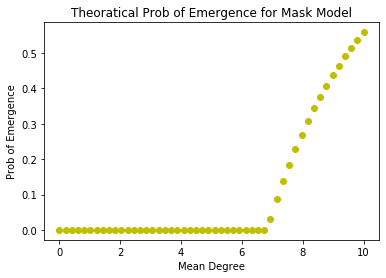

In [248]:
prob_emergence_list = []

for mean_degree in mean_degree_list:
    prob_emergence_list.append(sum(get_ProbEmergence(mean_degree, nodeN, Q1, Q2, m)))
    
plt.figure()
plt.plot(mean_degree_list, prob_emergence_list, 'yo')
plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Theoratical Prob of Emergence for Mask Model"
plt.title(title)

Text(0.5, 1.0, 'Theoratical Infection Fraction for Mask Model')

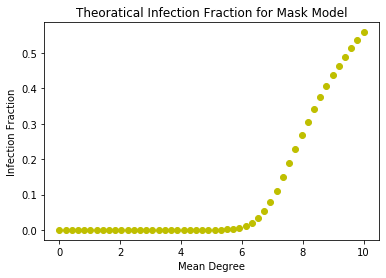

In [249]:
infection_size = []

for mean_degree in mean_degree_list:
#     print("Mean degree:", mean_degree)
    infection_size.append(sum(get_EpidemicSize(mean_degree, nodeN, Q1, Q2, m)))

plt.figure()
plt.plot(mean_degree_list, infection_size, 'yo')
plt.xlabel("Mean Degree")
plt.ylabel("Infection Fraction")
title = "Theoratical Infection Fraction for Mask Model"
plt.title(title)